### 一、通过代码实现简单线性回归模型

##### 1.导入波士顿房屋数据集

In [1]:
import pandas as pd

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


###### 2.探索性数据分析

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
'''
seaborn库是在matplotlib的基础上绘制统计图象的python库，调用pairplot()函数
可以绘制出两两之间的散点图。
'''
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5) # 该函数接收的参数只能是DataFrame对象，不能是numpy.ndarray
# sns.reset_orig() # 此函数用于把散点图的显示风格更改为matplotlib原本的风格
plt.show()

<Figure size 1250x1250 with 30 Axes>

从特征的直方图以及相互之间的散点图可以看出特征本身的分布规律以及特征之间的分布关系。例如，我们可直观看出RM和房屋价格MEDV（第5列和第4行）之间存在线性关系。此外，从MEDV直方图（散点图矩阵的右下角子图）中可以发现：MEDV看似呈正态分布，但包含几个异常值。

训练以额线性回归模型不需要解释变量或者目标变量呈正态分布。我们创建一个相关系数矩阵来量化特征之间的关系，此矩阵与协方差矩阵是密切相关的。实际上，相关系数矩阵就是将数据标准化后得到的协方差矩阵。

相关系数矩阵用来衡量两个特征之间的线性依赖关系。相关系数的取值范围是[-1， 1]，如果其值为1，则代表两个特征完全正相关；如果其值为-1，则代表两个特征之间完全互相关；如果其值为0则意味着两个特征不相关。两个变量之间的相关系数的计算公式如下所示：

$$
r=\frac{\sum_{i=1}^{n}\left[\left(x^{(i)}-\mu_{x}\right)\left(y^{(i)}-\mu_{y}\right)\right]}{\sqrt{\sum_{i=1}^{n}\left(x^{(i)}-\mu_{x}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(y^{(i)}-\mu_{y}\right)^{2}}}=\frac{\sigma_{x y}}{\sigma_{x} \sigma_{y}}
$$

经标准化以后的各特征间的协方差实际上等价于它们的线性相关系数。故可以先对特征进行标准化处理，然后通过计算它们的协方差来计算相关系数。以下代码展示了如果通过numpy库中计算协方差的函数corrcoef()来计算前面散点图中5个特征间的相关系数矩阵。并且使用seaborn库的heatmap函数绘制对应的热度图。

(5, 506)


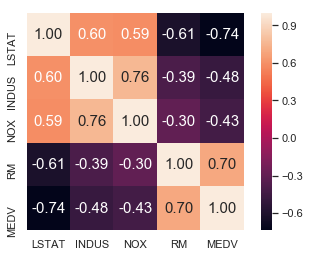

In [3]:
import numpy as np
print(df[cols].values.T.shape)
cm = np.corrcoef(df[cols].values.T) # 协方差是对整个样本集的特征列计算得到的，并且
                                    # 此函数规定矩阵中的每一行代表一个特征，故需要求转置的操作

sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols, xticklabels=cols)
plt.show()

###### 3.最小二乘法(OLS)估计回归曲线的参数

接下来，将通过最小二乘法(Ordinary Least Squares, OLS)估计回归曲线的参数，使得回归曲线到样本点垂直距离的平方和最小。

In [4]:
import numpy as np

class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        '''
        w_[0]保存的是偏置，w_[1:X.shape[1]保存的是权重矩阵
        如果是简单(一元)线性回归，X.shape[1]=1,也就是特征列的数目
        '''
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)     # output.shape=(506,)
            errors = (y - output)          # error.shape=(506,)
            self.w_[1:] += self.eta * X.T.dot(errors) # 根据权值更新的公式更新权重和偏置
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()/ 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

使用了房屋数据集中的RM（房间数量）作为解释变量来训练模型以预测MEDV（房屋价格）

In [5]:
X = df[['RM']].values # 两个中括号让其具有两个维度(矩阵的形式)
y = df[['MEDV']].values

from sklearn.preprocessing import StandardScaler

# 标准化处理，为了使得梯度下降算法收敛性能更佳
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X) # 传入此函数的数据必须是矩阵(二维)的形式，即[n_samples, n_features]，否则会报错
y_std = sc_y.fit_transform(y).flatten() # 数组(一维)跟矩阵(二维)进行加减计算会得到预期之外的结果，为了避免出错，将矩阵展平为数组

# 训练模型
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

# 绘制模型

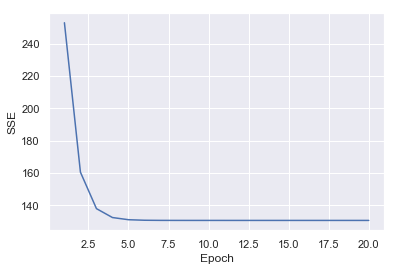

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [7]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

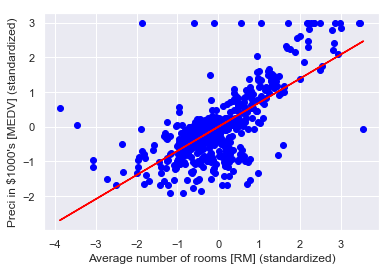

In [8]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Preci in $1000\'s [MEDV] (standardized)')
plt.show()

以上红色的直线便是我们拟合出来的回归线，显示了<font color=red>房间数量(RM)</font>与<font color=red>房屋价格(MEDV)</font>的线性关系。

In [9]:
num_rooms_std = sc_x.transform([[5.0]]) # 新的数据点需要用到训练集的均值和方差来标准化
price_std = lr.predict(num_rooms_std)
print('Price in $1000\'s: %.3f' % \
     sc_y.inverse_transform(price_std)) # 输出逆标准化的房屋价格

Price in $1000's: 10.840


In [10]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


打印出回归直线的权重跟偏置可以发现，用经过标准化处理的变量训练出来的回归线，在y轴上的截距始终为0。

### 二、通过scikit-learn库调用线性回归模型

In [11]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y) # 传入的数据是未经过标准化处理的原始的数据
print('Slope: %.3f' % slr.coef_[0])        # 斜率
print('Intercept: %.3f' % slr.intercept_)  # 截距

Slope: 9.102
Intercept: -34.671


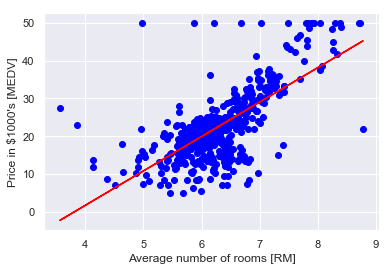

In [12]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

### 三、随机抽样一致性(Random Sample Consensus, RANSAC)算法

异常值对线性回归模型具有严重的影响，可以采用随机抽样一致性(Random Sample Consensus, RANSAC)算法来清除异样值。RANSAC算法的工作流程总结如下：

(1)从数据集中随机抽取样本构建内点集合来拟合模型。  
(2)使用剩余数据对上一步得到的模型进行测试，并将落在预定公差范围内的样本点增至内点集合。  
(3)使用全部内点集合数据再次进行模型的拟合。  
(4)使用内点集合来估计模型的误差。  
(5)如果模型性能达到了用户设定的特定阈值或者迭代达到了预定的次数，则算法终止，否则跳转到第一步。

##### 1.使用scikit-learn的RANSACRegressor对象来实现我们的线性模型

In [13]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                        max_trials=100, min_samples=50,  # 最大迭代次数和随机抽样的内点数
#                         residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,  # 设定的阈值，只有当剩余样本点与拟合直线的垂直距离小于5才会加入内点集合
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

###### 2.获取内点集合和异常值集合，并且将使用内点拟合得到的回归线一起绘制在一张图上

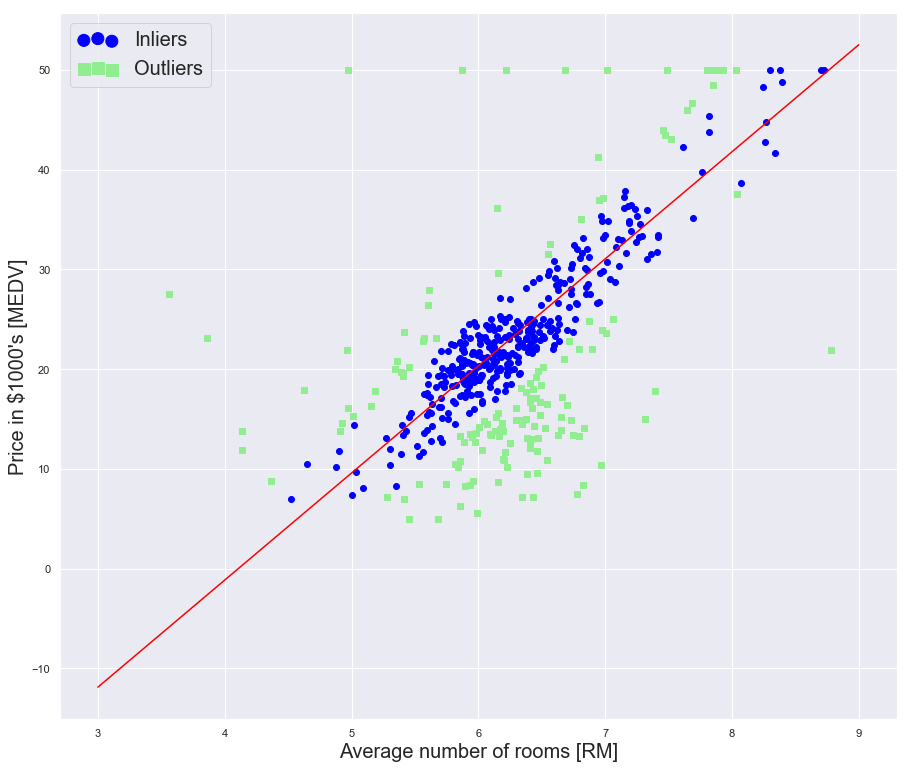

In [14]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis]) # line_X[:, np.newaxis]将数组转换成矩阵(二维)


plt.figure(figsize=(15, 13))
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]', fontsize=20)
plt.ylabel('Price in $1000\'s [MEDV]', fontsize=20)
plt.legend(loc='upper left', markerscale=2.0, numpoints=3, scatterpoints=3, fontsize=20)
plt.show()


###### 3.获取模型的斜率和截距

In [15]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


### 四、探讨回归模型评估的不同方法

###### 1.训练多元回归模型

在此之前我们训练了简单回归模型，现在使用波士顿房屋数据集中的所有特征变量训练多元回归模型。

In [31]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)

y_test_pred = slr.predict(X_test)

[ 4.58009023 28.38354012 17.27775551 29.39070404 20.54476971 15.75754584
 17.6247808  12.49442278  9.22920189 18.99918727 34.41440638 32.93511107
 23.12483827 19.46710569 22.74964337 26.62358085 21.76687195 16.99819925
 31.96065524 10.83525249 19.40870301 32.61288955 18.95461969 15.98186378
 18.61712222 14.38842624 24.83097587 23.82401975 16.76826477 13.84580415
 20.0779166  24.92266767 17.16189624 24.8364039  22.24174572 27.56012394
 35.90604682 17.04440455 12.33400373 34.74493343 30.90136127 20.49045946
 39.64478915 29.13249385 29.01388038 17.54994965 26.93066272 40.12543441
 28.81755964 16.66961044 37.3921316  35.14109319 13.69652069 29.0202751
 21.51233536 24.20704328 21.46319361 23.80022518 27.71918267 29.6616371
 14.66010846 25.7422347  23.1487446  13.27417646 13.9336657  25.4021242
 19.33272476 30.47117826 11.02963187 23.62001319 16.80574557 17.04252576
 22.07503746 21.7870848  11.56731564 25.17995099 28.63591914 20.14041637
 13.01330118 25.35764624 25.9211222  24.90848297 23.54

###### 2.残差图

由于模型拟合了多个特征变量，所以得到的应该是回归超平面，故无法在二维坐标上绘制出图形。我们转而绘制残差图，描述真实值与预测值之间的垂直距离，从而对模型进行评估。

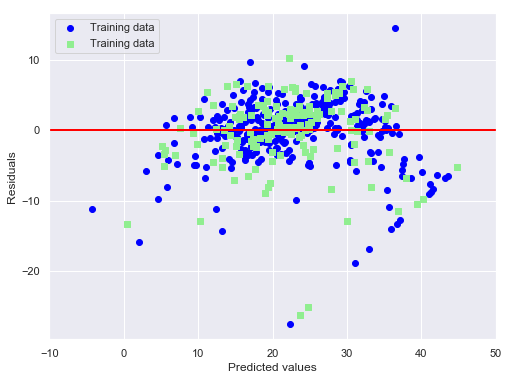

In [17]:

plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Training data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

完美的预测结果其残差应为0，但在实际应用中，这种情况可能永远都不会发生。对于一个好的回归模型，我们期望误差是随机分布的，同时残差也随机分布于中心线附近。如果我们从残差图中找出规律，这意味着模型遗漏了某些能够影响残差的解释信息，就如同刚看到的残差图那样，其中有着些许规律。此外，我们还可以使用残差图来发现异常值，这些异常值点看上去距离中心线有较大的偏差。

###### 3.均方误差

另外一种对模型性能进行定量评估的方法称为均方误差(Mean Squared Error, MSE),其计算公式如下：

$$
M S E=\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}
$$


In [18]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


###### 4.决定(R2)系数

某些情况下决定系数（coefficient of determination）（R2）显得尤为有用，它可以看作是MSE的标准化版本，用于更好地解释模型的性能。换句话说，R2是模型捕获的响应方差的分数。R2值的定义如下：

$$
\begin{aligned} R^{2} &=1-\frac{S S E}{S S T} \\ &=1-\frac{\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}}{\frac{1}{n} \sum_{i=1}^{n}\left(y^{(i)}-\mu_{y}\right)^{2}} \\ &=1-\frac{M S E}{\operatorname{Var}(y)} \end{aligned}
$$

对于训练数据集来说，R2的取值范围介于区间[0,1]，对于测试集来说，其值可能为负。如果R2＝1，此时MSE＝0，这意味着模型完美拟合了数据。

In [19]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred))) 

R^2 train: 0.765, test: 0.673


注：从以上方法可以看出模型出现了过拟合，为了解决过拟合问题，将在回归模型中引入正则化方法。

最常见的正则化线性回归方法就是所谓的岭回归（Ridge Regression）、最小绝对收缩及算子选择（Least Absolute Shrinkage and Selection Operator，LASSO）以及弹性网络（Elastic Net）等。

(1)岭回归是基于L2罚项的模型，我们只是在最小二乘代价函数中加入了权重的平方和： 

$$
J(w)_{\text {Ridge}}=\sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}+\lambda\|w\|_{2}^{2}
$$
其中：
$$
\mathrm{L} 2 : \quad \lambda\|w\|_{2}^{2}=\lambda \sum_{j=1}^{m} w_{j}^{2}
$$
(2)对于基于稀疏数据训练的模型，还有另外一种解决方案，即LASSO。基于正则化项的强度，某些权重可以变为零，这也使得LASSO成为一种监督特征选择技术： 

$$
J(w)_{L A S S O}=\sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}+\lambda\|w\|_{1}
$$
其中：
$$
\mathrm{L} 1 : \quad \lambda\|w\|_{1}=\lambda \sum_{j=1}^{m}\left|w_{j}\right|
$$

(3)不过LASSO存在一个限制，即如果m＞n，则至多可以完成n个变量的筛选。弹性网络则是岭回归和LASSO之间的一个折中，其中包含一个用于稀疏化的L1罚项，以及一个消除LASSO限制（如可筛选变量数量）的L2罚项。

$$
J(w)_{\text {ElasticNet}}=\sum_{i=1}^{n}\left(y^{(i)}-\hat{y}^{(i)}\right)^{2}+\lambda_{1} \sum_{j=1}^{m} w_{j}^{2}+\lambda_{2} \sum_{j=1}^{m}\left|w_{j}\right|
$$

In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet


ridge = Ridge(alpha=1.0) # 岭回归
lasso = Lasso(alpha=1.0) # LASSO回归
etnet = ElasticNet(alpha=1.0, l1_ratio=0.5) # 弹性网络

### 五、线性回归模型的曲线化(非线性数据的拟合)

#### 1.多项式回归

在前面的小节中，我们假定了单一解释变量与响应变量的线性关系。对于不符合线性假设的问题，一种常用的解释方法就是通过加入多项式项来使用多项式回归模型：  
$$
y=w^{0}+w_{1} x+w_{2} x^{2}+\cdots+w_{d} x^{d}
$$

其中，d为多项式的次数。虽然我们可以使用多项式回归对非线性关系建模，但由于线性回归系数w的缘故，多项式回归仍旧被看作是多元线性回归模型。

以下代码使用scikit-lern中的PolynominalFeatures转换类在只含一个解释变量的简单回归问题中加入二次项（d＝2），并且将多项式回归与线性回归进行线性拟合比较。步骤如下：

##### (1)增加一个二项式项

In [21]:
from sklearn.preprocessing import PolynomialFeatures

# 生成非线性数据集
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # 加入二次项
X_quad = quadratic.fit_transform(X)

###### (2)拟合一个简单线性回归模型

In [22]:
X_fit = np.arange(250, 600, 10)[:, np.newaxis] # 测试数据
lr.fit(X, y)
y_lin_fit = lr.predict(X_fit)

##### (3)使用经过转换后的特征针对多项式回归拟合一个多元线性回归模型

In [23]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

###### (4)打印输出结果

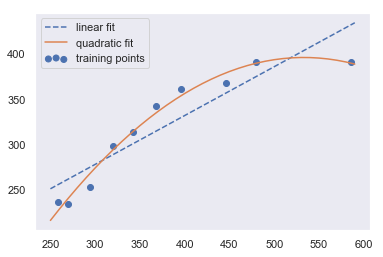

In [24]:
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left', scatterpoints=3)
plt.grid(False) # 取消图的网格
plt.show()

从结果图像中可以看出，与线性拟合相比，多项式拟合可以更好地捕获到解释变量与响应变量之间的关系。

###### (5)对模型进行评估(打印均方误差，R2分数)

In [25]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)


print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred), mean_squared_error(y, y_quad_pred)))
print('Training R2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred), r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R2 linear: 0.832, quadratic: 0.982


#### 2.波士顿房屋数据集的非线性关系建模

通过执行下面的代码，我们将使用二次和三次多项式对房屋价格和LSTAT（弱势群体人口所占比例）之间的关系进行建模，并与线性拟合进行对比。

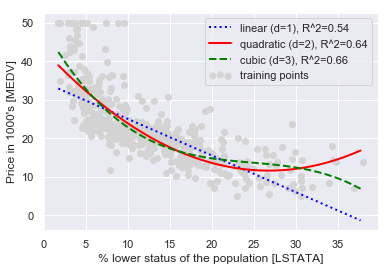

In [26]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()
quadratic = PolynomialFeatures(degree=2) # 二次项
cubic = PolynomialFeatures(degree=3)     # 三次拟

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr1 = regr.fit(X, y)
y_lin_fit = regr1.predict(X_fit)
linear_r2 = r2_score(y, regr1.predict(X))

# quadratic fit
regr2 = regr.fit(X_quad, y)
y_quad_fit = regr2.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr2.predict(X_quad))

# cubic fit
regr3 = regr.fit(X_cubic, y)
y_cubic_fit = regr3.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, label='linear (d=1), R^2=%.2f' % linear_r2, color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), R^2=%.2f' % quadratic_r2, color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), R^2=%.2f' % cubic_r2, color='green', lw=2, linestyle='--')


plt.xlabel('% lower status of the population [LSTATA]')
plt.ylabel('Price in 1000\'s [MEDV]')
plt.legend(loc='upper right', scatterpoints=3)
plt.show()

由结果图像可知，相较于线性拟合和二次拟合，三次拟合更好地捕获了房屋价格与LSTAT之间的关系。不过，我们应该意识到，加入越来越多的多项式特征会增加模型的复杂度，从而更易导致过拟合。

多项式特征并非总是非线性关系建模的最佳选择。例如，仅就MEDV-LSTAT的散点图来说，我们可将LSTAT特征变量的对数值以及MEDV的平方根映射到一个线性特征空间，并使用线性回归进行拟合。可通过执行下面的代码对此假设进行验证：

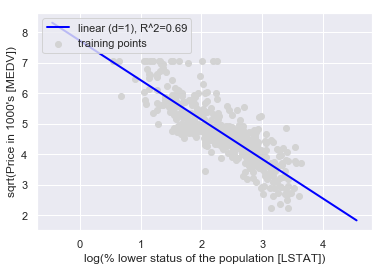

In [27]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, label='linear (d=1), R^2=%.2f' % linear_r2, color='blue', lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('sqrt(Price in 1000\'s [MEDV])')
plt.legend(loc='upper left', )
plt.show()

###### 3.使用随机森林处理非线性关系

随机森林是多棵决策树(decision tree)的集合，与先前介绍的线性回归和多项式回归不同，它可以被理解为分段线性函数的集成。换句话说，通过决策树算法，我们把输入空间细分为更小的区域以更好地管理。

决策树算法的一个优点在于：如果我们处理的是非线性数据，无需对其进行特征转换。我们迭代地对节点进行划分来构建决策树，直到所有叶子节点的不纯度为0，或者满足终止条件时才停止迭代。

我们的目标是通过特征的划分来使得信息增益最大化，换句话说，我们试图找到使得子节点中信息不纯度最低的特征划分。为了将决策树用于回归，我们使用MSE替代熵作为节点的不纯度度量标准。

为了知道**决策树**的拟合效果，我们使用scikit-learn中的DecisionTreeRegressor类对MEDV和LSTAT两个变量之间的非线性关系进行建模：

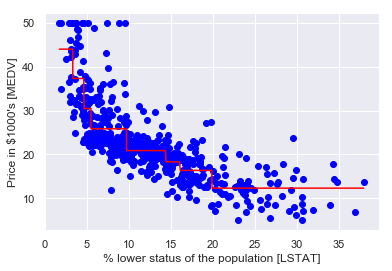

In [28]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort() # 展平成数组以后排序，用于绘制拟合曲线,argsort()返回的是排序以后的数组下标

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

从结果图中可以看到，决策树捕捉到了数据的整体趋势。不过，此模型的一个局限在于：它无法捕获期望预测的连续性与可导性。下面讨论**随机森林回归**的方法。

随机森林算法是组合多棵决策树的一种集成技术。由于随机性有助于降低模型的方差，与单棵决策树相比，随机森林通常具有更好的泛化性能。随机森林的另一个优势在于：它对数据集中的异常值不敏感，且无需过多的参数调优。随机森林中唯一需要我们通过实验来获得的参数就是待集成决策树的数量。随机森林回归与随机森林分类的唯一区别在于：随机森林用均方误差(MSE)作为单棵决策树生成的标准，同时所有决策树预测值的平均数作为预测目标变量的值。

以下代码使用波士顿房屋数据集中的所有特征来拟合一个随机森林回归模型，其中训练集中的样本数占60%，测试集中的样本数占40%。

In [29]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = \
                        train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)

forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))


MSE train: 1.641, test: 11.056
R^2 train: 0.979, test: 0.878


从测试集的均方误差偏大的情况可以看出随机森林回归模型出现了过拟合。绘制残差图看看模型效果。

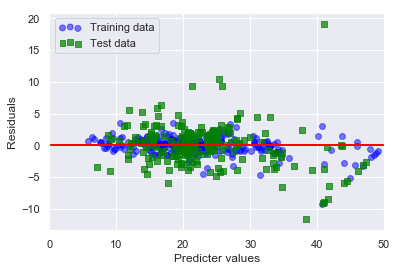

In [30]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', s=35, alpha=0.5, label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, c='green', marker='s', s=35, alpha=0.7, label='Test data')

plt.xlabel('Predicter values')
plt.ylabel('Residuals')
plt.legend(loc='upper left', scatterpoints=3)
plt.hlines(y=0,xmin=0, xmax=50, lw=2, color='red')
plt.xlim([0, 50])
plt.show()

我们已经讨论过核技巧，并将其应用到了支持向量机(SVM)的分类中，若需要处理非线性问题，此技巧是非常有用的,实践证明，支持向量机也可以用于非线性回归任务。

总结：我们学习了如何使用简单回归模型对单个解释变量和连续目标变量之间的关系进行建模。进而，我们讨论了一种用于了解数据中模式与异常点的解释性数据分析技术。基于梯度优化的方法，我们构建并实现了第1个线性回归模型。我们学习了如何使用scikit-learn中的线性回归模型，并且针对异常值的处理实现了一个鲁棒的线性回归模型（RANSAC）。为了更深入了解回归模型的预测性能，我们计算了误差平方和的平均值，以及R2等衡量标准。此外，我们还讨论了一种诊断回归模型中所存在问题的图像化方法：残差图。我们讨论了如何将正则化方法应用于回归模型，以降低模型复杂度及避免过拟合，此外还介绍了非线性关系建模的几种方法，包括多项式特征转换和随机森林回归。